<a href="https://colab.research.google.com/github/jaishrm07/deep-learning-projects/blob/main/pets_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
import re
import torch
# # Set the device to CPU
# device = torch.device("cpu")

In [ ]:
# import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
# import os

# # Optionally unset the fallback environment variable
# if "PYTORCH_ENABLE_MPS_FALLBACK" in os.environ:
#     del os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]

In [ ]:
# import torch

# # Check if MPS is available and set the device
# if torch.backends.mps.is_available():
#     device = torch.device('mps')  # Use the GPU
# else:
#     device = torch.device('cpu')  # Fallback to CPU if MPS is not available

# print(f"Using device: {device}")

Using device: mps


In [2]:
path = untar_data(URLs.PETS)

In [ ]:
# path = untar_data(URLs.PETS, dest="/Users/jaisharma/JAI_MB_SSD/Programming/Deep Learning/fastai_PyTorch/images")

In [ ]:
# from pathlib import Path

# new_path = Path("/Users/jaisharma/JAI_MB_SSD/Programming/Deep Learning/fastai_PyTorch")
# #print(new_path.ls())

# len((new_path/"images").ls())

7393

In [ ]:
#!zip -r pets_data.zip /root/.fastai/data/oxford-iiit-pet/

In [ ]:
# from google.colab import files
# files.download('pets_data.zip')

In [3]:
(path/"images").ls() # this returns a list of all the images in the directory "images"

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_172.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_199.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_130.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_91.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_134.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_22.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_181.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_122.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_145.jpg')...]

In [4]:
(path/"annotations").ls()

(#7) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps')]

In [5]:
fname = (path/"images").ls()[0] # this returns the name of file along with the paths
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_172.jpg')

In [6]:
re.findall(r'(.+)_\d+.jpg$', fname.name)  # to access file name from fname use fname.name

['basset_hound']

### Data Block API (fastAI)

The DataBlock API allows you to define a flexible data pipeline by specifying how to load, split, label, and transform your data.

- blocks = (ImageBlock, CategoryBlock)

	•	ImageBlock: Specifies that the input data consists of images.
	•	CategoryBlock: Specifies that the labels are categorical (for classification tasks). In this case, the categories represent different pet breeds.

- get_items=get_image_files

	•	get_items: Defines how to retrieve the dataset items (in this case, images). get_image_files is a fastAI utility function that finds and returns all image files in the specified directory.

- splitter=RandomSplitter(seed=42)

	•	splitter: Defines how to split the dataset into training and validation sets. RandomSplitter splits the data randomly, and the seed=42 ensures the split is reproducible (so you get the same split every time you run the code).

- get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')

	•	get_y: Defines how to extract labels from the data. This line uses the RegexLabeller, which applies a regular expression to the filenames to extract the label. The regex r'(.+)_\d+.jpg$' captures the part of the filename before the underscore (which represents the category). The using_attr(..., 'name') tells fastAI to apply this labeler to the file’s name attribute (i.e., the filename).

- item_tfms=Resize(460)

	•	item_tfms: Defines item-level transformations. Resize(460) resizes each image to 460 pixels on the smaller edge, preserving aspect ratio. This is called presizing, which prepares the image for data augmentation while minimizing data loss (important for model performance).

- batch_tfms=aug_transforms(size=224, min_scale=0.75)

	•	batch_tfms: Defines batch-level transformations (applied after item_tfms). aug_transforms performs image augmentation, which includes a variety of transformations like flipping, zooming, and cropping. size=224 resizes the images to 224x224 pixels (after presizing), and min_scale=0.75 ensures that when zooming, at least 75% of the image is retained, minimizing image distortion.

In [7]:
# # learn about data block API of fastAI - to define custom data blocks
# The DataBlock API allows you to define a flexible data pipeline by specifying how to load, split, label, and transform your data.

pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460), # used to do presizing -- way to do image augmentation that is designed to minimize data destruction
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

'''
This line creates the DataLoaders object (dls) from the pets DataBlock.

	•	path/"images": Specifies the directory where the images are stored. The dataloaders method will:
	•	Load the images from the folder.
	•	Split the data into training and validation sets using the RandomSplitter.
	•	Apply the transformations defined in item_tfms and batch_tfms.
	•	Return a DataLoaders object, which contains the training and validation datasets, ready for model training.

'''

dls = pets.dataloaders(path/"images")

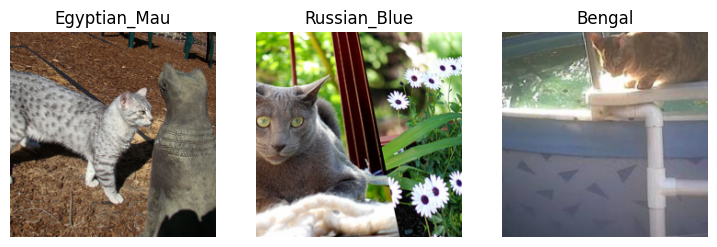

In [8]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
# pets.summary(path/"images")

In [9]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.2MB/s]


In [10]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.567202,0.315338,0.101489,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.527546,0.322606,0.103518,01:10
1,0.324970,0.240240,0.071719,01:15


In [11]:
# using confusion matrix to see where our model is doing well and where it's doing badly.

interp = ClassificationInterpretation.from_learner(learn)


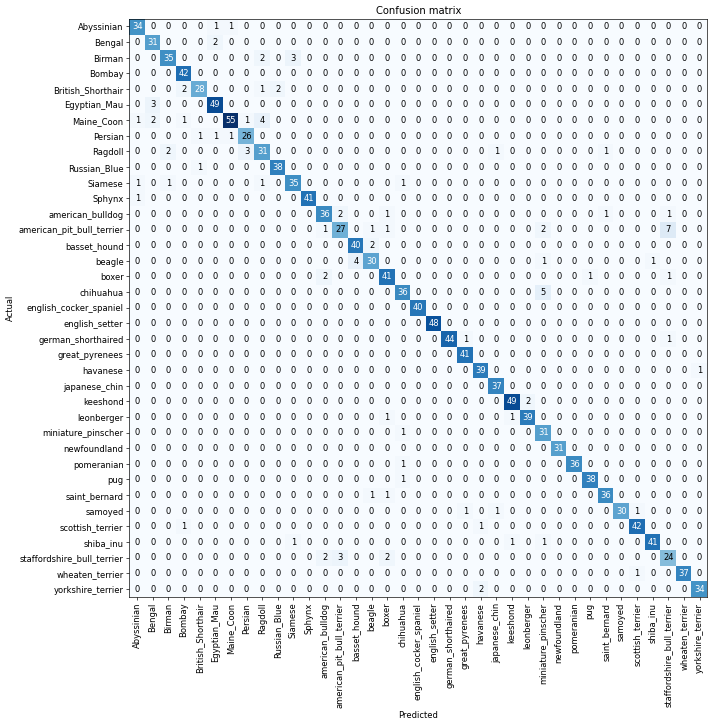

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('chihuahua', 'miniature_pinscher', 5)]

In [16]:
# the learning rate finder

learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [17]:
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.718202,4.706740,0.442490,01:13


epoch,train_loss,valid_loss,error_rate,time
0,3.358152,1.622660,0.474966,01:13


In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

ValueError: not enough values to unpack (expected 2, got 1)

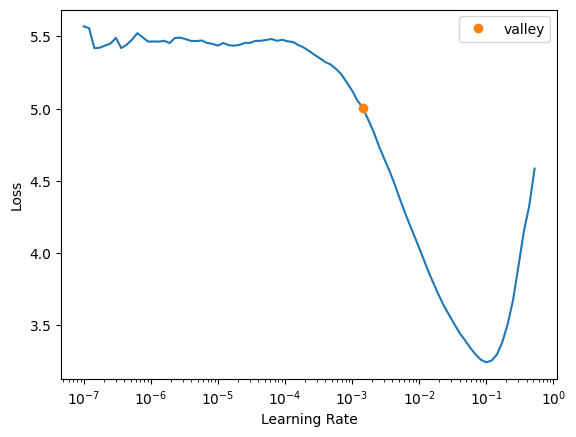

In [21]:
lr_min, lr_steep = learn.lr_find()

In [22]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

NameError: name 'lr_min' is not defined

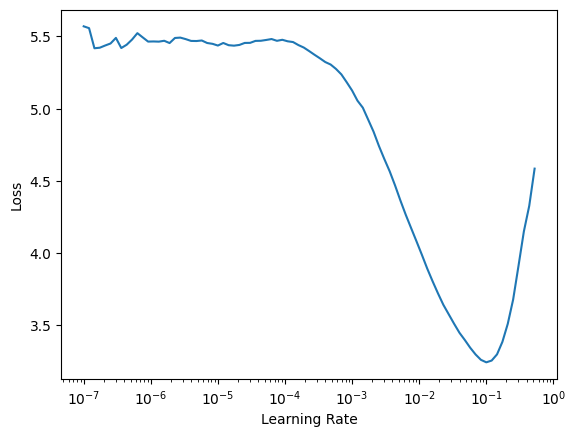

In [23]:
learn.recorder.plot_lr_find()

In [24]:
# going by this graph learning rate = 3e-3

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.283601,0.325325,0.113667,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.524357,0.333810,0.099459,01:13
1,0.331851,0.230935,0.067659,01:15


In [25]:
### trasnfer learning using fastAI


learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.101806,0.293807,0.094723,01:08
1,0.526442,0.242068,0.078484,01:11
2,0.319042,0.214093,0.062246,01:08


In [26]:
learn.unfreeze()

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=4.786300905834651e-06)

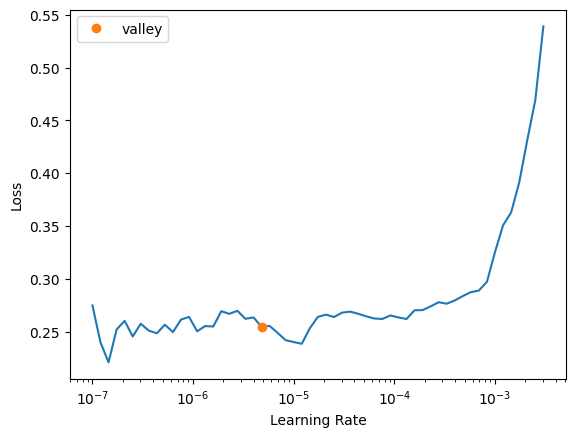

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.240342,0.210289,0.061570,01:15
1,0.242086,0.202831,0.058863,01:13
2,0.228461,0.194689,0.058187,01:10
3,0.199569,0.189610,0.057510,01:10
4,0.176741,0.189589,0.054127,01:12
5,0.182604,0.186438,0.053451,01:11


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

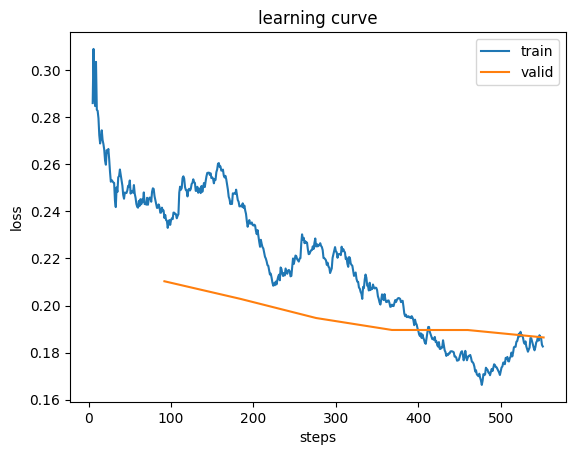

In [29]:
learn.recorder.plot_loss()